In [ ]:
# !pip install ydata_profiling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso, LassoCV
# from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Regression task

## Gather and preprocess your regression dataset.

In [ ]:
# Loading Data from a JSON File
with open('/content/drive/MyDrive/Colab Notebooks/ML/Lab 4/couriers_data.json', 'r') as file:
    data = pd.read_json(file)

In [ ]:
# Profiling data
# report = ProfileReport(data)
# report.to_file('data_profile_report.html')

From the report, it is evident that the data contains categorical features that need to be processed. To do this, you can use Label Encoding or one-hot encoding. In this task, the mode of transportation can be considered as ordinal variables.

In [ ]:
# Handling Categorical Features
category_mapping = {
    "foot": 1,
    "bicycle": 2,
    "scooter": 3,
    "automobile": 4,
}

data['courier_transport'] = data['courier_transport'].map(category_mapping)

It is also visible from the report that we have two columns with timestamps that, according to the task conditions, we will no longer need after performing the required calculations. Let's perform the necessary calculations and drop the two timestamp columns.

In [ ]:
# Transformation of timestamp columns
data['work_start'] = pd.to_datetime(data['work_start'])
data['work_finish'] = pd.to_datetime(data['work_finish'])

# Calculating the difference between 'work_finish' and 'work_start' in minutes.
data['hours_engaged'] = (data['work_finish'] - data['work_start']).dt.total_seconds() / 60

# Removing the two columns 'work_start' and 'work_finish'.
data.drop(['work_start', 'work_finish'], axis=1, inplace=True)

After loading and processing the data, we need to split it into features and targets.

In [ ]:
# We split the data into features and targets.
X = data.drop('total_deliveries', axis=1)
y = data[['total_deliveries']]


Next, it is necessary to split the data into training and testing datasets in order to conduct the training and performance evaluation of the machine learning model.

In [ ]:
# We split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)

To ensure neutrality towards the weight of different features, we apply data scaling.

In [ ]:
# We scale the data.
columns_to_scale = [name for name in X_train.columns if name != 'courier_transport']
scaler = StandardScaler()

scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

## Feature selection and creation.

To assess feature importance and select the best features for further training, we will train two models: Lasso and LassoCV. After comparing their results, we will be able to determine which features can be excluded from our dataset for more effective model training.

In [ ]:
# Let's create an instance of the Lasso model:
lasso = Lasso()
lasso.fit(X_train, y_train)

print('Lasso coef', lasso.coef_)

y_pred = lasso.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination  R2:', metrics.r2_score(y_test, y_pred))

Lasso coef [-0.          0.          3.3185418  -0.         -0.          0.91680957]
Mean Absolute Error: 2.654705257599654
Root Mean Squared Error: 3.6618011933926153
Coefficient of determination  R2: 0.5532542199934867


In [ ]:
# Let's create an instance of LassoCV with cross-validation:
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)

print('LassoCV coef', lasso_cv.coef_)

y_pred = lasso_cv.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination  R2:', metrics.r2_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV coef [ 0.          0.2633966   3.94543263 -0.08829676 -0.24219562  1.52772364]
Mean Absolute Error: 2.255459837065044
Root Mean Squared Error: 3.447522622445247
Coefficient of determination  R2: 0.6040091195153425


Based on the results:

Lasso has an MAE (Mean Absolute Error) of approximately 2.710, an RMSE (Root Mean Squared Error) of approximately 3.880, and an R-squared (R2) of approximately 0.593.

LassoCV has an MAE of approximately 2.400, an RMSE of approximately 3.648, and an R2 of approximately 0.640.

From these metrics, we can conclude that LassoCV performs better, as it has lower MAE and RMSE values and a higher R2 value, indicating more accurate and explainable predictions.

However, it's worth noting that LassoCV shows only a slight improvement compared to Lasso, while Lasso removes a larger number of features. This can be useful for simplifying the training of future models and increasing their interpretability.

In [ ]:
# Obtaining coefficients for each feature
feature_coefficients = lasso.coef_
print(lasso.coef_)

# We create a list of selected features.
selected_features = X_train.columns[feature_coefficients != 0]

# We create a mask for the selected features.
selected_feature_mask = feature_coefficients != 0

# We use the mask to select the features.
X_train_selected = X_train.iloc[:, selected_feature_mask]
X_test_selected = X_test.iloc[:, selected_feature_mask]

[-0.          0.          3.3185418  -0.         -0.          0.91680957]


In [ ]:
# Предполагаемые данные (замените их на свои данные)
input_dim = 6  # Количество входных признаков
hidden_dim = 64  # Количество нейронов в скрытом слое
output_dim = 1  # Количество выходных признаков (для регрессии это обычно 1)

# Создаем кастомную модель регрессии
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Создаем модель
model = RegressionModel(input_dim, hidden_dim, output_dim)

# Задаем критерий потерь и оптимизатор
criterion = nn.MSELoss()  # Среднеквадратичная ошибка для регрессии
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Используем оптимизатор Adam

# Создаем фиктивные данные для демонстрации обучения
# import numpy as np
# X_train = torch.FloatTensor(np.random.rand(100, input_dim))
# y_train = torch.FloatTensor(np.random.rand(100, output_dim))

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    # Сбросим градиенты
    optimizer.zero_grad()

    # Прямой проход
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Обратный проход и оптимизация
    loss.backward()
    optimizer.step()

    # Выводим информацию о процессе обучения
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели на тестовых данных (замените на свои данные)
# X_test = torch.FloatTensor(np.random.rand(10, input_dim))
# y_pred = model(X_test)
# print("Predicted Output:")
# print(y_pred)

Epoch [10/100], Loss: 109.8892
Epoch [20/100], Loss: 102.4128
Epoch [30/100], Loss: 95.2293
Epoch [40/100], Loss: 88.2419
Epoch [50/100], Loss: 81.3670
Epoch [60/100], Loss: 74.5530
Epoch [70/100], Loss: 67.7902
Epoch [80/100], Loss: 61.1138
Epoch [90/100], Loss: 54.5942
Epoch [100/100], Loss: 48.3321


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Оценка модели на X_train
with torch.no_grad():
    # Используем обученную модель для предсказания
    y_pred_train = model(X_train)

    # Вычисляем MAE
    mae = mean_absolute_error(y_train, y_pred_train)

    # Вычисляем MSE
    mse = mean_squared_error(y_train, y_pred_train)

    # Вычисляем RMSE
    rmse = np.sqrt(mse)

    # Выводим метрики
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Absolute Error (MAE): 5.0516
Root Mean Square Error (RMSE): 6.9083
Mean Squared Error (MSE): 47.7242


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Оценка модели
with torch.no_grad():
    # Замените на свои тестовые данные
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # Используем обученную модель для предсказания
    y_pred_test = model(X_test)

    # Вычисляем MAE
    mae = mean_absolute_error(y_test, y_pred_test)

    # Вычисляем MSE
    mse = mean_squared_error(y_test, y_pred_test)

    # Вычисляем RMSE
    rmse = np.sqrt(mse)

    # Выводим метрики
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Absolute Error (MAE): 4.3615
Root Mean Square Error (RMSE): 6.1620
Mean Squared Error (MSE): 37.9707


In [ ]:
# # Вычисляем среднеквадратичную ошибку (MSE)
# mse = nn.MSELoss()
# mse_loss = mse(y_pred, y_test)

# # Вычисляем среднеквадратичную ошибку (MSE)
# mae = nn.MAELoss()
# mae_loss = mae(y_pred, y_test)

# # Вычисляем среднеквадратичную ошибку (MSE)
# mse = nn.MSELoss()
# mse_loss = mse(y_pred, y_test)

# # Выводим MSE и другие метрики, если необходимо
# print(f"Mean Squared Error (MAE): {mse_loss.item():.4f}")
# print(f"Mean Squared Error (MSE): {mse_loss.item():.4f}")
# print(f"Root Mean Squared Error (RMSE): {mse_loss.item():.4f}")

# Classification task

## Gather and preprocess your regression dataset.

In [ ]:
# Using dataset given to you in previous self practice task.
# Loading Data from a JSON File
with open('/content/drive/MyDrive/Colab Notebooks/ML/Lab 4/order_cancellation_data.json', 'r') as file:
    data = pd.read_json(file)

In [ ]:
# report = ProfileReport(data)
# report.to_file('data_profile_report.html')

In [ ]:
# Replacing the categorical feature in the 'order_status' column.
data['order_status'] = data['order_status'].replace({'F':1, 'C':0})

In [ ]:
# Sorting the data by date and dropping this column.
data.sort_values(by='order_create_time', inplace=True)
data.drop('order_create_time', axis=1, inplace=True)

In [ ]:
# Dropping rows with zero values in the "total_order_items" column.
data = data[data['total_order_items'] > 0]
# Removing outliers (dropping all values greater than the 95th percentile).
data = data[data['total_order_items'] <= 8]

In [ ]:
# I'm filling the missing (NaN) values in the "cost(USD)" column with the mean values.
data['cost(USD)'].fillna(data['cost(USD)'].mean(), inplace=True)
# I'm dropping rows with values less than 8 in the "cost(USD)" column.
data = data[data['cost(USD)'] >= 8]
# I'm removing outliers by dropping all values that are greater than the 95th percentile in the "cost(USD)" column.
data = data[data['cost(USD)'] <= 21.32]

In [ ]:
# I'm dropping rows with zero values in the "payment_type" column.
data['payment_type'].dropna(inplace=True)

# We will convert categorical features into numerical ones using one-hot encoding.
data = pd.get_dummies(data, columns=['payment_type'])

In [ ]:
# Filling in missing (NaN) values in the "vendor_client_distance" column with the mean values.
data['vendor_client_distance'].fillna(data['vendor_client_distance'].mean(), inplace=True)
# Removing outliers by dropping all values greater than the 95th percentile in the "vendor_client_distance" column.
data = data[data['vendor_client_distance'] <= 9818]

In [ ]:
# Filling missing (NaN) values in the "estimated_delivery_time" column with the mean values.
data['estimated_delivery_time'].fillna(data['estimated_delivery_time'].mean(), inplace=True)
# Removing outliers by dropping all rows with values greater than the 95th percentile in the "estimated_delivery_time" column.
data = data[data['estimated_delivery_time'] <= 102]

In [ ]:
# Filling missing (NaN) values in the "predicted_order_preparation_time" column with the mean values.
data['predicted_order_preparation_time'].fillna(data['predicted_order_preparation_time'].mean(), inplace=True)
# Removing outliers by dropping all rows with values greater than the 95th percentile in the "predicted_order_preparation_time" column.
data = data[data['predicted_order_preparation_time'] <= 31]

In [ ]:
data.drop(columns=['vendor_id'], axis=1, inplace=True)

## Normalize or standardize your data (optional) and split it into training and testing sets.

In [ ]:
# We split the data into features and the target variable.
X = data.drop('order_status', axis=1)
y = data[['order_status']]

In [ ]:
print(len(y.loc[y['order_status'] == 1]))
print(y.shape)

69746
(80515, 1)


In [ ]:
# Divide the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)

In [ ]:
# # Data balancing
# smote = SMOTE()
# X_train_normalized_resampled, X_test_normalized_resampled = smote.fit_resample(X_train_normalized, X_test_normalized)

In [ ]:
# # Scaling the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train_resampled)
# X_test = scaler.transform(X_test)

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Convert data to PyTorch tensor
X_train, X_test = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
# Create DataLoader for tranning data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

## Define the architecture of your ANN for classification, including the number of layers, units in each layer, and activation functions.

In [ ]:
class ANNForClassificationModel(nn.Module):
  def __init__(self, input_dim):
    super(ANNForClassificationModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

## Compile the Model:

*   Choose an appropriate loss function for classification, such as categorical cross-entropy.
*   Select an optimizer and specify evaluation metrics like accuracy.


## Training:

Train the model on your training data.

*   Train the model on your training data.
*   Monitor training progress and make adjustments as necessary to minimize the loss.

In [ ]:
model = ANNForClassificationModel(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

losses = []

In [ ]:
for epoch in range(num_epochs):
  model.train()
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

## Evaluation:

*   Use the trained model to make predictions on your test data.
*   Calculate accuracy, precision, recall, F1-score, and confusion matrices to evaluate classification performance.

Accuracy: 0.8543
Precision: 0.8543
Recall: 1.0000
F1-Score: 0.9214


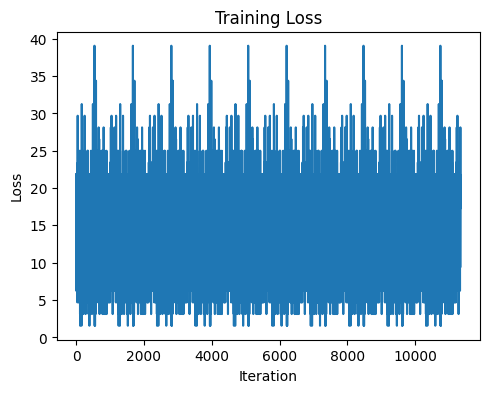

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred >= 0.5).float()

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Step 5: Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

# You can also plot other evaluation metrics here
# For example, a Receiver Operating Characteristic (ROC) curve

plt.show()